In [1]:
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [2]:
def gen_block(x, filters = 128, kernel_size = 5, strides = 2, padding = "same"):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
    return x

def build_generator(inputs, image_size):
  image_resize = image_size // 4
  x = Dense(image_resize * image_resize * 128)(inputs)
  x = Reshape((image_resize, image_resize, 128))(x)
  x = gen_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 32, kernel_size = 5, strides = 1, padding = "same")
  x = gen_block(x = x, filters = 1, kernel_size = 5, strides = 1, padding = "same")
  x = Activation('sigmoid')(x)
  generator = Model(inputs, x, name = "generator")
  return generator


def disc_block(x, filters = 64, kernel_size = 5, strides = 2, padding = "same"):
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
  return x

def build_discriminator(inputs):
   x = inputs
   x = LeakyReLU(alpha = 0.2)(x)
   x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(x)
   x = disc_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 256, kernel_size = 5, strides = 1, padding = "same")
   x = Flatten()(x)
   x = Dense(1)(x)
   x = Activation("linear")(x)
   discriminator = Model(inputs, x, name = 'discriminator')
   return discriminator

In [4]:
(x_train, _), (_ , _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "lsgan_mnist"
latent_size = 100 # latent vector of 100-dim
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 5000 # one can train for more number of steps to get better quality
input_shape = (image_size, image_size, 1)

# discriminator model
inputs = Input(shape = input_shape, name = "discriminator_input")
discriminator = build_discriminator(inputs)
discriminator.compile(loss = "mse",
                      optimizer = RMSprop(learning_rate = lr, weight_decay = decay),
                      metrics = ['accuracy'])
discriminator.summary()

# generator model
input_shape = (latent_size,)
inputs = Input(shape = input_shape, name = 'generator_input')
generator = build_generator(inputs, image_size)
generator.summary()

# adversarial model
discriminator.trainable = False
adversarial = Model(inputs, discriminator(generator(inputs)), name = model_name)
adversarial.compile(loss = "mse",
                    optimizer = RMSprop(learning_rate = lr * 0.5, weight_decay = decay * 0.5),
                    metrics = ['accuracy'])
adversarial.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)        

In [8]:
def train(models, x_train, params):

  generator, discriminator, adversarial = models
  batch_size, latent_size, train_steps, model_name = params
  save_interval = 500

  noise_input = np.random.uniform(-1.0, 1.0, size = [16, latent_size])
  train_size = x_train.shape[0]

  for i in range(train_steps):
    rand_indexes = np.random.randint(0, train_size, size = batch_size)
    real_images = x_train[rand_indexes]
    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_images = generator.predict(noise)

    x = np.concatenate((real_images, fake_images))
    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0.0

    loss, acc = discriminator.train_on_batch(x, y)
    log = f"{i}: [Discriminator Loss: {loss}, acc: {acc}]"
    print(log)

    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    y = np.ones([batch_size, 1])
    loss, acc = adversarial.train_on_batch(noise, y)
    log = f"{i}: [Adversarial Loss: {loss}, acc: {acc}]"
    print(log)

    if (i + 1) % save_interval == 0:
      os.makedirs(model_name, exist_ok=True)
      filename = os.path.join(model_name, f"{i + 1:05d}.png")
      images = generator.predict(noise_input)
      plt.figure(figsize=(2.2, 2.2))
      num_images = images.shape[0]
      image_size = images.shape[1]
      rows = int(math.sqrt(noise_input.shape[0]))
      for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
      plt.savefig(filename)
      plt.show()

  generator.save(model_name + ".keras")

2/2 [==============================] - 1s 292ms/step
0: [Discriminator Loss: 0.19150134921073914, acc: 0.921875]
0: [Adversarial Loss: 0.8752936124801636, acc: 0.0]
2/2 [==============================] - 1s 366ms/step
1: [Discriminator Loss: 0.20135995745658875, acc: 0.4921875]
1: [Adversarial Loss: 0.9778286218643188, acc: 0.0]
2/2 [==============================] - 0s 167ms/step
2: [Discriminator Loss: 0.20804741978645325, acc: 0.953125]
2: [Adversarial Loss: 0.8530329465866089, acc: 0.0]
2/2 [==============================] - 0s 166ms/step
3: [Discriminator Loss: 0.26748132705688477, acc: 0.453125]
3: [Adversarial Loss: 0.986733078956604, acc: 0.0]
2/2 [==============================] - 0s 167ms/step
4: [Discriminator Loss: 0.3671274185180664, acc: 0.9609375]
4: [Adversarial Loss: 0.8072349429130554, acc: 0.0]
2/2 [==============================] - 1s 278ms/step
5: [Discriminator Loss: 0.5444557070732117, acc: 0.4921875]
5: [Adversarial Loss: 1.011747121810913, acc: 0.0]
2/2 [======

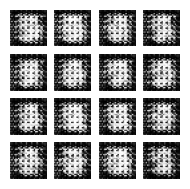

2/2 [==============================] - 1s 290ms/step
500: [Discriminator Loss: 0.14983515441417694, acc: 0.859375]
500: [Adversarial Loss: 0.6075844764709473, acc: 0.0]
2/2 [==============================] - 0s 179ms/step
501: [Discriminator Loss: 0.08223013579845428, acc: 1.0]
501: [Adversarial Loss: 1.4058345556259155, acc: 0.0]
2/2 [==============================] - 0s 171ms/step
502: [Discriminator Loss: 0.07758519798517227, acc: 0.8984375]
502: [Adversarial Loss: 0.7312139272689819, acc: 0.0]
2/2 [==============================] - 0s 186ms/step
503: [Discriminator Loss: 0.0818517804145813, acc: 1.0]
503: [Adversarial Loss: 1.5309644937515259, acc: 0.0]
2/2 [==============================] - 0s 167ms/step
504: [Discriminator Loss: 0.06817930936813354, acc: 0.96875]
504: [Adversarial Loss: 0.5757095813751221, acc: 0.0]
2/2 [==============================] - 1s 275ms/step
505: [Discriminator Loss: 0.09409846365451813, acc: 0.953125]
505: [Adversarial Loss: 1.8056623935699463, acc: 0.

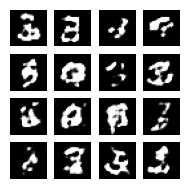

2/2 [==============================] - 0s 166ms/step
1000: [Discriminator Loss: 0.14156551659107208, acc: 0.78125]
1000: [Adversarial Loss: 0.7382245063781738, acc: 0.046875]
2/2 [==============================] - 0s 175ms/step
1001: [Discriminator Loss: 0.1559453308582306, acc: 0.7890625]
1001: [Adversarial Loss: 1.0544239282608032, acc: 0.03125]
2/2 [==============================] - 0s 190ms/step
1002: [Discriminator Loss: 0.15481969714164734, acc: 0.7890625]
1002: [Adversarial Loss: 0.9114566445350647, acc: 0.015625]
2/2 [==============================] - 0s 178ms/step
1003: [Discriminator Loss: 0.17363663017749786, acc: 0.703125]
1003: [Adversarial Loss: 0.9371548891067505, acc: 0.09375]
2/2 [==============================] - 1s 280ms/step
1004: [Discriminator Loss: 0.15302154421806335, acc: 0.7890625]
1004: [Adversarial Loss: 0.6545028686523438, acc: 0.125]
2/2 [==============================] - 0s 165ms/step
1005: [Discriminator Loss: 0.1584133505821228, acc: 0.796875]
1005: [Ad

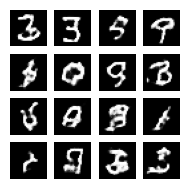

2/2 [==============================] - 0s 185ms/step
1500: [Discriminator Loss: 0.14713704586029053, acc: 0.8046875]
1500: [Adversarial Loss: 0.5753703117370605, acc: 0.171875]
2/2 [==============================] - 0s 214ms/step
1501: [Discriminator Loss: 0.15616323053836823, acc: 0.78125]
1501: [Adversarial Loss: 0.45770639181137085, acc: 0.28125]
2/2 [==============================] - 0s 174ms/step
1502: [Discriminator Loss: 0.12946045398712158, acc: 0.828125]
1502: [Adversarial Loss: 0.6072551012039185, acc: 0.203125]
2/2 [==============================] - 0s 184ms/step
1503: [Discriminator Loss: 0.1365710347890854, acc: 0.8203125]
1503: [Adversarial Loss: 0.3609846830368042, acc: 0.453125]
2/2 [==============================] - 0s 168ms/step
1504: [Discriminator Loss: 0.13551148772239685, acc: 0.8203125]
1504: [Adversarial Loss: 0.721147894859314, acc: 0.125]
2/2 [==============================] - 0s 169ms/step
1505: [Discriminator Loss: 0.15782567858695984, acc: 0.7578125]
1505: 

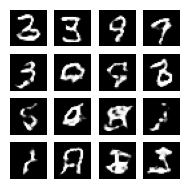

2/2 [==============================] - 1s 275ms/step
2000: [Discriminator Loss: 0.1835753619670868, acc: 0.7421875]
2000: [Adversarial Loss: 0.46883267164230347, acc: 0.234375]
2/2 [==============================] - 0s 174ms/step
2001: [Discriminator Loss: 0.15063712000846863, acc: 0.8046875]
2001: [Adversarial Loss: 0.4837494492530823, acc: 0.203125]
2/2 [==============================] - 0s 172ms/step
2002: [Discriminator Loss: 0.15103083848953247, acc: 0.796875]
2002: [Adversarial Loss: 0.5075016021728516, acc: 0.25]
2/2 [==============================] - 0s 177ms/step
2003: [Discriminator Loss: 0.13698062300682068, acc: 0.8359375]
2003: [Adversarial Loss: 0.4947037100791931, acc: 0.234375]
2/2 [==============================] - 1s 281ms/step
2004: [Discriminator Loss: 0.17499619722366333, acc: 0.7734375]
2004: [Adversarial Loss: 0.5494009852409363, acc: 0.1875]
2/2 [==============================] - 0s 169ms/step
2005: [Discriminator Loss: 0.15164491534233093, acc: 0.796875]
2005: 

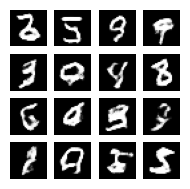

2/2 [==============================] - 0s 173ms/step
2500: [Discriminator Loss: 0.17346663773059845, acc: 0.7578125]
2500: [Adversarial Loss: 0.5032477974891663, acc: 0.203125]
2/2 [==============================] - 0s 174ms/step
2501: [Discriminator Loss: 0.14953917264938354, acc: 0.7890625]
2501: [Adversarial Loss: 0.6217714548110962, acc: 0.046875]
2/2 [==============================] - 1s 291ms/step
2502: [Discriminator Loss: 0.153724804520607, acc: 0.8125]
2502: [Adversarial Loss: 0.522403359413147, acc: 0.1875]
2/2 [==============================] - 0s 173ms/step
2503: [Discriminator Loss: 0.1356179267168045, acc: 0.84375]
2503: [Adversarial Loss: 0.6088827848434448, acc: 0.140625]
2/2 [==============================] - 0s 175ms/step
2504: [Discriminator Loss: 0.1603965312242508, acc: 0.765625]
2504: [Adversarial Loss: 0.5062621831893921, acc: 0.25]
2/2 [==============================] - 0s 175ms/step
2505: [Discriminator Loss: 0.16253376007080078, acc: 0.78125]
2505: [Adversaria

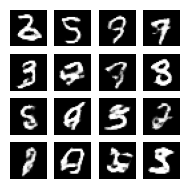

2/2 [==============================] - 0s 170ms/step
3000: [Discriminator Loss: 0.14624109864234924, acc: 0.8125]
3000: [Adversarial Loss: 0.5853970050811768, acc: 0.109375]
2/2 [==============================] - 1s 274ms/step
3001: [Discriminator Loss: 0.15018993616104126, acc: 0.75]
3001: [Adversarial Loss: 0.5317807793617249, acc: 0.265625]
2/2 [==============================] - 0s 185ms/step
3002: [Discriminator Loss: 0.13373655080795288, acc: 0.8203125]
3002: [Adversarial Loss: 0.4803789258003235, acc: 0.265625]
2/2 [==============================] - 0s 173ms/step
3003: [Discriminator Loss: 0.15963979065418243, acc: 0.8046875]
3003: [Adversarial Loss: 0.5973799228668213, acc: 0.125]
2/2 [==============================] - 0s 176ms/step
3004: [Discriminator Loss: 0.16467387974262238, acc: 0.7734375]
3004: [Adversarial Loss: 0.408620148897171, acc: 0.28125]
2/2 [==============================] - 0s 181ms/step
3005: [Discriminator Loss: 0.1551029086112976, acc: 0.7421875]
3005: [Adver

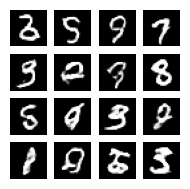

2/2 [==============================] - 0s 187ms/step
3500: [Discriminator Loss: 0.16082404553890228, acc: 0.7578125]
3500: [Adversarial Loss: 0.3778151869773865, acc: 0.4375]
2/2 [==============================] - 0s 175ms/step
3501: [Discriminator Loss: 0.17887508869171143, acc: 0.75]
3501: [Adversarial Loss: 0.6941105127334595, acc: 0.109375]
2/2 [==============================] - 1s 281ms/step
3502: [Discriminator Loss: 0.13524509966373444, acc: 0.8046875]
3502: [Adversarial Loss: 0.35221171379089355, acc: 0.453125]
2/2 [==============================] - 0s 176ms/step
3503: [Discriminator Loss: 0.13844923675060272, acc: 0.8359375]
3503: [Adversarial Loss: 0.4109967350959778, acc: 0.34375]
2/2 [==============================] - 0s 178ms/step
3504: [Discriminator Loss: 0.17326690256595612, acc: 0.7578125]
3504: [Adversarial Loss: 0.3872021436691284, acc: 0.40625]
2/2 [==============================] - 0s 187ms/step
3505: [Discriminator Loss: 0.1296599805355072, acc: 0.84375]
3505: [Ad

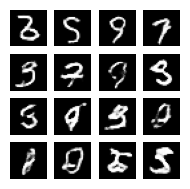

2/2 [==============================] - 1s 299ms/step
4000: [Discriminator Loss: 0.17593029141426086, acc: 0.7421875]
4000: [Adversarial Loss: 0.5507567524909973, acc: 0.21875]
2/2 [==============================] - 0s 180ms/step
4001: [Discriminator Loss: 0.1773732602596283, acc: 0.7578125]
4001: [Adversarial Loss: 0.4005683660507202, acc: 0.296875]
2/2 [==============================] - 0s 179ms/step
4002: [Discriminator Loss: 0.1338977962732315, acc: 0.796875]
4002: [Adversarial Loss: 0.41170233488082886, acc: 0.359375]
2/2 [==============================] - 0s 183ms/step
4003: [Discriminator Loss: 0.1477435678243637, acc: 0.7578125]
4003: [Adversarial Loss: 0.5320875644683838, acc: 0.15625]
2/2 [==============================] - 0s 176ms/step
4004: [Discriminator Loss: 0.12270712107419968, acc: 0.84375]
4004: [Adversarial Loss: 0.406973659992218, acc: 0.296875]
2/2 [==============================] - 0s 176ms/step
4005: [Discriminator Loss: 0.17073647677898407, acc: 0.7421875]
4005: 

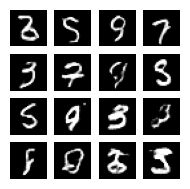

2/2 [==============================] - 0s 179ms/step
4500: [Discriminator Loss: 0.1722523421049118, acc: 0.7421875]
4500: [Adversarial Loss: 0.5218455195426941, acc: 0.21875]
2/2 [==============================] - 0s 181ms/step
4501: [Discriminator Loss: 0.14631348848342896, acc: 0.78125]
4501: [Adversarial Loss: 0.2407272756099701, acc: 0.5625]
2/2 [==============================] - 1s 283ms/step
4502: [Discriminator Loss: 0.1629895567893982, acc: 0.7734375]
4502: [Adversarial Loss: 0.46324145793914795, acc: 0.203125]
2/2 [==============================] - 0s 178ms/step
4503: [Discriminator Loss: 0.16223756968975067, acc: 0.75]
4503: [Adversarial Loss: 0.23419442772865295, acc: 0.59375]
2/2 [==============================] - 0s 181ms/step
4504: [Discriminator Loss: 0.19366979598999023, acc: 0.7265625]
4504: [Adversarial Loss: 0.6528749465942383, acc: 0.09375]
2/2 [==============================] - 0s 181ms/step
4505: [Discriminator Loss: 0.15879935026168823, acc: 0.78125]
4505: [Adver

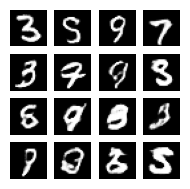

In [9]:
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, model_name)
train(models, x_train, params)

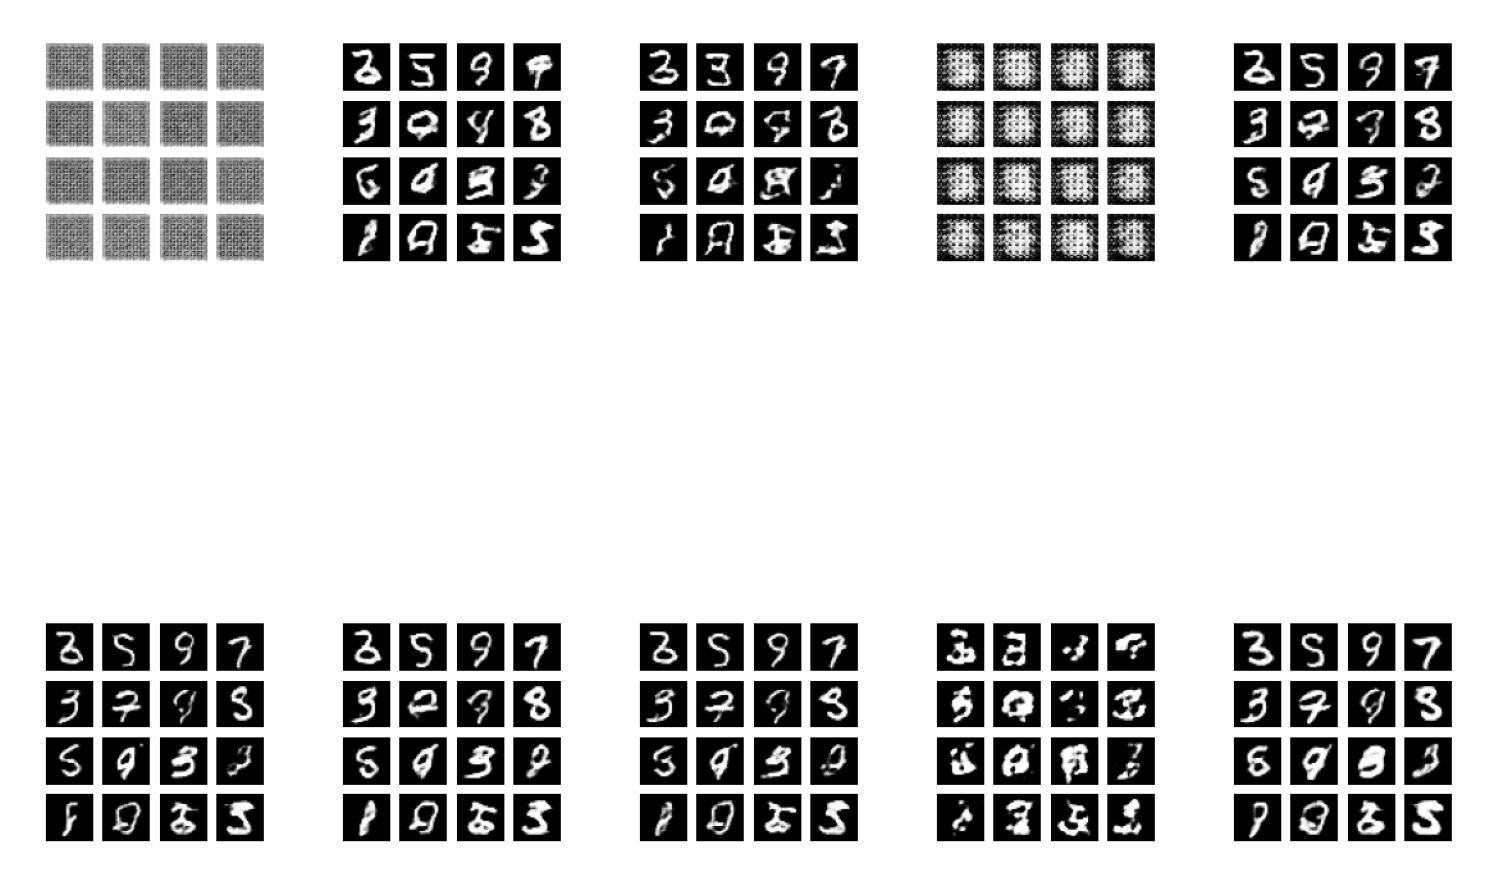

In [10]:
import matplotlib.image as mpimg
def load_images(image_dir):
    images = []
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        img = mpimg.imread(img_path)
        images.append(img)
    return images

def plot_images_in_grid(images, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

image_dir = '/content/lsgan_mnist'
images = load_images(image_dir)
plot_images_in_grid(images, (2, 5))